In [1]:
%matplotlib inline 

# Regression
***

## Table of Contents
***
* [Aim](#aim)
* [Code Setup](#code-setup)
* [Data Import](#data-import)

## Aim <a class="anchor" id="aim"></a>
***

The aim of this notebook is to perform Regression on the Instacart Data

## Code Setup <a class="anchor" id="code-setup"></a>
***

### Constants

In [2]:
instacart_dir = "instacart_2017_05_01/"
my_orders_file = "my_orders.csv"
products_file = "products.csv"
aisles_file = "aisles.csv"
departments_file = "departments.csv"
orders_products_prior_file = "my_order_products__prior.csv"
orders_products_train_file = "my_order_products__train.csv"

### Import Libraries

In [3]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [4]:
def read_csv_file(file_name):
    return pd.read_csv(instacart_dir + file_name)

### Import the Data

In [5]:
orders = read_csv_file(my_orders_file)
products = read_csv_file(products_file)
aisles = read_csv_file(aisles_file)
orders_products_prior = read_csv_file(orders_products_prior_file)
orders_products_train = read_csv_file(orders_products_train_file)
orders_products = pd.concat([orders_products_prior, orders_products_train])

In [6]:
def join_products(train, test):
    train_orders_prod = train.merge(orders_products, on="order_id")
    train_orders_prod = train_orders_prod.merge(products, on="product_id")

    test_orders_prod = test.merge(orders_products, on="order_id")
    test_orders_prod = test_orders_prod.merge(products, on="product_id")
    
    return (train_orders_prod, test_orders_prod)

In [7]:
def add_days_to_next_order(order_df):
    orders = order_df.copy()
    orders["days_to_next_order"] = np.nan
    for index, cur_order in orders.iterrows():
        next_order_number = cur_order.order_number + 1
        user_id = cur_order.user_id
        next_order_df = orders.query("user_id == " + str(user_id) + " and  order_number == " + str(next_order_number))
        if(next_order_df.shape[0] == 1):
            next_order = next_order_df.iloc[0]
            days_to_next_order = next_order.days_since_prior_order
            if(np.isfinite(days_to_next_order)):
                orders.loc[index, 'days_to_next_order'] = days_to_next_order
    return orders

In [8]:
def key_columns(next_one):
    list = ["order_id", "days_to_next_order", next_one]
    return list

In [9]:
def split_data_to_features_and_value(df_train, df_test):
    # Target
    y_train = df_train['days_to_next_order'].copy()
    X_train = df_train.copy() 
    # Feature
    X_train.drop(['days_to_next_order'], axis=1, inplace=True)

    # Testing
    y_test = df_test['days_to_next_order'].copy()
    X_test = df_test.copy() 
    # Feature
    X_test.drop(['days_to_next_order'], axis=1, inplace=True)
    return (X_train, y_train, X_test, y_test)

In [10]:
def add_each_aisle_to_df(df):
    df_aisles = df.copy().merge(aisles, on="aisle_id")
    for index, row in aisles.iterrows():
        aisle_name = row.aisle
        df_aisles[aisle_name] = 0
    return df_aisles

In [11]:
def add_each_department_to_df(df):
    df_dep = df.copy().merge(departments, on="department_id")
    for index, row in departments.iterrows():
        department_name = row.department
        df_dep[department_name] = 0
    return df_dep

In [12]:
def add_each_product_to_df(df, popular_products):
    df_products = df.copy().merge(products, on="product_id")
    for index, row in popular_products.iterrows():
        product_name = row.product_name
        df_products[product_name] = 0
    return df_products

In [13]:
def group_by_order_in_df(df_ordered, item_name, cols_to_drop):
    # Create new df with only the column names
    df = df_ordered.copy()
    df.drop(df.index, inplace=True)
    order_ids = df_ordered.order_id.unique().tolist()
    for order_id in order_ids:
        temp_df = df_ordered.query("order_id == " + str(order_id))
        # Need a copy as not to modify something we are iterarting over
        first_row = temp_df.copy().head(1)
        for i, temp_row in temp_df.iterrows():
            temp_name = temp_row[item_name]
            # If the feature is present, set it to 1
            if temp_name in df.columns:
                first_row[temp_name] = 1
        # Add the aggregated entry
        df = pd.concat([df, first_row])
    df = df.drop(cols_to_drop, axis=1)
    return df    

In [14]:
def find_best_feature(X, y, X_test, y_test):
    n_features = X.shape[1]
    # Not zero as some negative scores can happen
    max_score = -100000
    max_feature = None
    for i in range(n_features):
        feature = X.columns[i]
        X_subset = X[[feature]]
        X_test_subset = X_test[[feature]]
        model = linear_model.LinearRegression()
        model.fit(X_subset, y)
        # R squared metric
        score = model.score(X_test_subset, y_test)
        if score > max_score:
            max_score = score
            max_feature = feature
    if max_feature is None :
        print("Issue, max feature not found, size", n_features)
        print(X.columns.values)
    return (max_score, max_feature)

In [15]:
# This is a very brute force way computing all possibilities of finding the solution with the highest score
def order_best_features_and_score(X_train, y_train, X_test, y_test):
    n_features = X_train.shape[1]
    model_scores = [0]
    best_features = []
    best_score = -10000
    X_selection = X_train.copy()
    X_test_selection = X_test.copy()
    X_subsets = pd.DataFrame(index=X_train.index)
    X_test_subsets = pd.DataFrame(index=X_test.index)

    for i in range(n_features):
        max_score, next_best_feature = find_best_feature(X_selection, y_train, X_test_selection, y_test)

        X_subset = X_selection[[next_best_feature]]
        X_test_subset = X_test_selection[[next_best_feature]]
    
        X_subsets[next_best_feature] = X_subset
        X_test_subsets[next_best_feature] = X_test_subset
        
        model = linear_model.LinearRegression()
        model.fit(X_subsets, y_train)
        score = model.score(X_test_subsets, y_test)
        model_scores.append(score)
        
        score_increase_threshold = 0.01
        if score > (best_score + score_increase_threshold):
            best_score = score
            best_features = X_subsets.columns.values

        X_selection.drop([next_best_feature], axis=1, inplace=True)
        X_test_selection.drop([next_best_feature], axis=1, inplace=True)
    return (best_features, best_score, model_scores)

#### Test and training split for all users

In [16]:
test_percentage = 0.2
orders = add_days_to_next_order(orders)
# Can use this to estimate what would be ordered
orders_with_no_next_order = orders[orders['days_to_next_order'].isnull()]
# Can split this into train and test
orders_with_next_order = orders[~orders['days_to_next_order'].isnull()]
train_orders, test_orders = train_test_split(orders_with_next_order, test_size=test_percentage)
print("Training size is :", train_orders.shape[0])
print("Testing size is :", test_orders.shape[0])

Training size is : 228
Testing size is : 58


#### Test and training split for specific user

In [17]:
count_orders = (orders
                .groupby("user_id")
                .size()
                .reset_index(name="count")
                .sort_values(by=['count'], ascending=False)
               )
# Get the most frequent user as this will have the most data associated with it
most_frequeny_user_id =  count_orders.iloc[0].user_id
single_user_orders = orders.query("user_id == " + str(most_frequeny_user_id))
single_user_orders = add_days_to_next_order(single_user_orders)
user_orders_with_next_order = single_user_orders[~single_user_orders['days_to_next_order'].isnull()]
user_train_orders, user_test_orders = train_test_split(user_orders_with_next_order, test_size=test_percentage)
print("User id for single investigation :", most_frequeny_user_id)
print("Training size for single user is :", user_train_orders.shape[0])
print("Testing size for single user is is :", user_test_orders.shape[0])

User id for single investigation : 47562
Training size for single user is : 70
Testing size for single user is is : 18


### Merge Product and Aisle to the data

In [18]:
train_orders_prod, test_orders_prod = join_products(train_orders, test_orders)
train_orders_prod.head()

,Unnamed: 0_x,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_to_next_order,Unnamed: 0_y,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2487361,817217,149715,prior,25,2,15,16.0,30.0,7742638,21019,1,0,Roasted Red Pepper Hummus,67,20
1,790817,3155755,47562,prior,20,3,15,2.0,1.0,29919474,21019,6,1,Roasted Red Pepper Hummus,67,20
2,790802,324368,47562,prior,5,3,8,1.0,5.0,3072687,21019,13,0,Roasted Red Pepper Hummus,67,20
3,2487361,817217,149715,prior,25,2,15,16.0,30.0,7742639,20405,2,0,Disposable Vinyl Gloves,118,11
4,2487361,817217,149715,prior,25,2,15,16.0,30.0,7742640,2588,3,1,Wild Wonders Medley Tomato,83,4


## Product Investigation
***

In [19]:
key_cols = key_columns("product_id")
wanted_info_train = train_orders_prod[key_cols]
wanted_info_test = test_orders_prod[key_cols]

wanted_info_train.head()

,order_id,days_to_next_order,product_id
0,817217,30.0,21019
1,3155755,1.0,21019
2,324368,5.0,21019
3,817217,30.0,20405
4,817217,30.0,2588


### Add Product Columns

In [20]:
# Only doing what products are currenty present in training set and appeared more than once to reduce number of products
min_time_prod_appear = 3
popular_products_ids = (wanted_info_train
                        .groupby("product_id")
                        .size()
                        .reset_index(name="count")
                        .query("count >= " + str(min_time_prod_appear))
                        .product_id
                        .tolist()
                       )
popular_products = products[products['product_id'].isin(popular_products_ids)]
df_with_product_info_train = add_each_product_to_df(wanted_info_train, popular_products)
df_with_product_info_test = add_each_product_to_df(wanted_info_test, popular_products)

In [21]:
cols_to_drop = ["product_id", "product_name", "order_id", "department_id", "aisle_id"]
item = "product_name"
df_prod_group_train = group_by_order_in_df(df_with_product_info_train, item, cols_to_drop)
df_prod_group_test = group_by_order_in_df(df_with_product_info_test, item, cols_to_drop)

df_prod_group_train.head()

,days_to_next_order,Organic Diced Tomatoes,"Noodle Soup, Shin Cup, Gourmet Spicy",Kidz All Natural Baked Chicken Nuggets,Cherry Pomegranate Greek Yogurt,Apple Jacks Cereal,Vitamin C Super Orange Dietary Supplement,Yellow Bell Pepper,Wild Wonders Medley Tomato,Dark Chocolate with Whole Hazelnuts,...,Total 0% Nonfat Greek Yogurt,Raisin Cinnamon Swirl Bread,Cream Cheese Stuffed Jalapenos Poppers,Asparagus,S'mores Chocolate Ice Cream,Large Lemon,Organic Avocado,Sweet Onion,Organic Half & Half,Cucumber Kirby
0,30.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
6,6.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
X_train, y_train, X_test, y_test = split_data_to_features_and_value(df_prod_group_train, df_prod_group_test)
# Where X are the features and Y is the days to next order (value trying to predict)
X_train.head()

,Organic Diced Tomatoes,"Noodle Soup, Shin Cup, Gourmet Spicy",Kidz All Natural Baked Chicken Nuggets,Cherry Pomegranate Greek Yogurt,Apple Jacks Cereal,Vitamin C Super Orange Dietary Supplement,Yellow Bell Pepper,Wild Wonders Medley Tomato,Dark Chocolate with Whole Hazelnuts,Mountain Spring Water,...,Total 0% Nonfat Greek Yogurt,Raisin Cinnamon Swirl Bread,Cream Cheese Stuffed Jalapenos Poppers,Asparagus,S'mores Chocolate Ice Cream,Large Lemon,Organic Avocado,Sweet Onion,Organic Half & Half,Cucumber Kirby
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### PCA

In [23]:
# Fit on training set only.
scaler.fit(X_train)


X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Make an instance of the Model
variance = 0.8
pca = PCA(variance)
pca.fit(X_train_scale)

train = pca.transform(X_train_scale)
test = pca.transform(X_test_scale)

model = linear_model.LinearRegression()
model.fit(train, y_train)
model.score(test, y_test)
# This Looks good
#https://stats.stackexchange.com/questions/82050/principal-component-analysis-and-regression-in-python
#https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

0.2708744179127509

In [24]:
print(len(X_train))

228


In [25]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
model.intercept_

15.529759457236842

In [26]:
find_best_feature(X_train, y_train, X_test, y_test)

(0.19368545640287982, '2% Reduced Fat Organic Milk')

In [27]:
best_features, best_score, model_scores = order_best_features_and_score(X_train, y_train, X_test, y_test)
print("Best Score :", best_score)
print(best_features)

Best Score : 0.45586593824258925
['2% Reduced Fat Organic Milk' 'Bag of Organic Bananas'
 'Fat Free Strawberry Yogurt' 'Vanilla Almond Breeze' 'Frosted Flakes'
 'Coke Classic' 'Total 0% Raspberry Yogurt' 'Organic Strawberries'
 'Romaine Hearts' 'Organic Small Bunch Celery'
 'Raisin Cinnamon Swirl Bread' 'Honey Nut Cheerios' 'Cucumber Kirby'
 'Total 2% Greek Strained Yogurt with Cherry 5.3 oz'
 'Premium Pure Cane Granulated Sugar' 'Raisin Bran Cereal'
 'GOLEAN Crunch! Cereal' 'Organic Avocado' 'Honey Nut Chex Cereal'
 'Sausage, Egg, & Cheese Biscuit'
 'Total 2% Lowfat Greek Strained Yogurt With Blueberry' 'Organic Broccoli'
 'Apple Jacks Cereal' 'Cherry Pomegranate Greek Yogurt' 'Beer'
 'Premium Lager Beer' 'Lager' 'Total 0% Nonfat Greek Yogurt'
 'Total 2% with Strawberry Lowfat Greek Strained Yogurt'
 'Yellow Bell Pepper' 'Bagel Thins Everything']


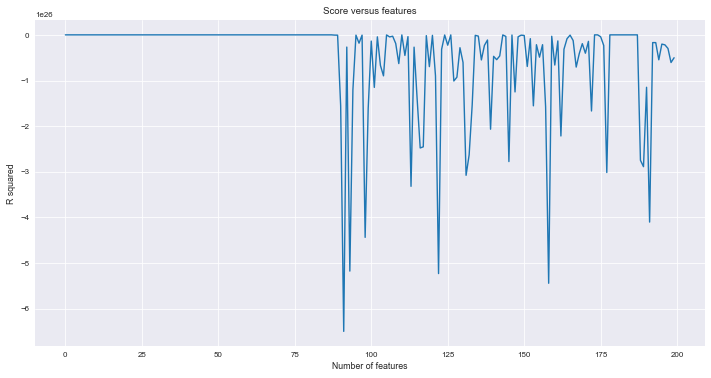

In [28]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores)
plt.show()

In [29]:
nbfs, nbs, model_scores = order_best_features_and_score(X_train[best_features], y_train, X_test[best_features], y_test)
print("Best Score :", nbs)
print(nbfs)

Best Score : 0.45586593824258925
['2% Reduced Fat Organic Milk' 'Bag of Organic Bananas'
 'Fat Free Strawberry Yogurt' 'Vanilla Almond Breeze' 'Frosted Flakes'
 'Coke Classic' 'Total 0% Raspberry Yogurt' 'Organic Strawberries'
 'Romaine Hearts' 'Organic Small Bunch Celery'
 'Raisin Cinnamon Swirl Bread' 'Honey Nut Cheerios' 'Cucumber Kirby'
 'Total 2% Greek Strained Yogurt with Cherry 5.3 oz'
 'Premium Pure Cane Granulated Sugar' 'Raisin Bran Cereal'
 'GOLEAN Crunch! Cereal' 'Organic Avocado' 'Honey Nut Chex Cereal'
 'Sausage, Egg, & Cheese Biscuit'
 'Total 2% Lowfat Greek Strained Yogurt With Blueberry' 'Organic Broccoli'
 'Apple Jacks Cereal' 'Cherry Pomegranate Greek Yogurt' 'Beer'
 'Premium Lager Beer' 'Lager' 'Total 0% Nonfat Greek Yogurt'
 'Total 2% with Strawberry Lowfat Greek Strained Yogurt'
 'Yellow Bell Pepper' 'Bagel Thins Everything']


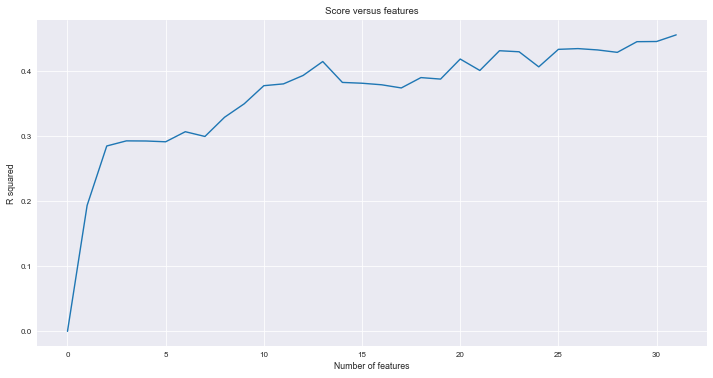

In [30]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores)
plt.show()

## Aisle Rollup
***

### Extract Desired Columns

In [31]:
key_cols = key_columns("aisle_id")
wanted_info_train = train_orders_prod[key_cols]
wanted_info_test = test_orders_prod[key_cols]

wanted_info_train.head()

,order_id,days_to_next_order,aisle_id
0,817217,30.0,67
1,3155755,1.0,67
2,324368,5.0,67
3,817217,30.0,118
4,817217,30.0,83


### Add the Aisle Columns

In [32]:
df_with_aisle_info_train = add_each_aisle_to_df(wanted_info_train)
df_with_aisle_info_test = add_each_aisle_to_df(wanted_info_test)

df_with_aisle_info_train.head()

,order_id,days_to_next_order,aisle_id,aisle,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,817217,30.0,67,fresh dips tapenades,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3155755,1.0,67,fresh dips tapenades,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,324368,5.0,67,fresh dips tapenades,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,184276,30.0,67,fresh dips tapenades,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3125525,2.0,67,fresh dips tapenades,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Populate the Aisle Columns

In [33]:
# Aggregates the data so we have days to next order with the aisles required checked
cols_to_drop = ["aisle", "aisle_id", "order_id"]
item = "aisle"
df_aisle_group_train = group_by_order_in_df(df_with_aisle_info_train, item, cols_to_drop)
df_aisle_group_test = group_by_order_in_df(df_with_aisle_info_test, item, cols_to_drop)

df_aisle_group_train.head()

,days_to_next_order,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,30.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Preparing the data for modelling

In [34]:
X_train, y_train, X_test, y_test = split_data_to_features_and_value(df_aisle_group_train, df_aisle_group_test)
# Where X are the features and Y is the days to next order (value trying to predict)
X_train.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Generate the Model

In [35]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
model.intercept_

12.996895660007533

### Find the best feature/aisle

In [36]:
find_best_feature(X_train, y_train, X_test, y_test)

(0.1108709540723678, 'hot dogs bacon sausage')

### Find best features in Order and calculate scores

In [37]:
best_features, best_score, model_scores = order_best_features_and_score(X_train, y_train, X_test, y_test)
print("Best Score :", best_score)
print(best_features)

Best Score : 0.3965664961421045
['hot dogs bacon sausage' 'fresh vegetables' 'packaged vegetables fruits'
 'milk' 'yogurt' 'juice nectars' 'frozen breakfast' 'instant foods'
 'soft drinks' 'spreads' 'energy sports drinks' 'tofu meat alternatives'
 'soy lactosefree' 'beers coolers' 'fresh herbs' 'canned meat seafood'
 'cereal' 'hot cereal pancake mixes' 'dry pasta' 'packaged produce'
 'packaged cheese' 'eggs' 'spices seasonings' 'frozen produce'
 'pasta sauce']


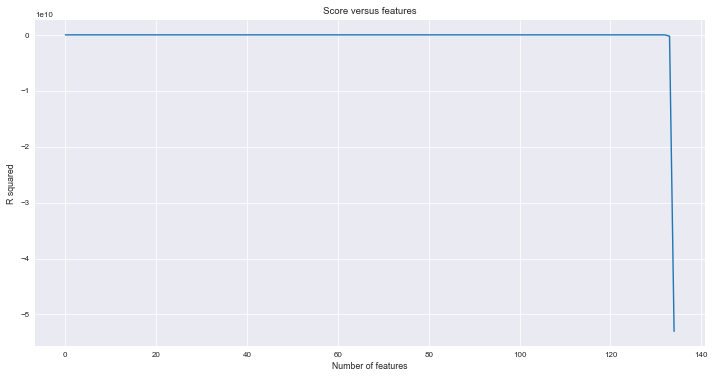

In [38]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores)
plt.show()

In [39]:
nbfs, nbs, model_scores = order_best_features_and_score(X_train[best_features], y_train, X_test[best_features], y_test)
print("Best Score :", nbs)
print(nbfs)

Best Score : 0.3965664961421045
['hot dogs bacon sausage' 'fresh vegetables' 'packaged vegetables fruits'
 'milk' 'yogurt' 'juice nectars' 'frozen breakfast' 'instant foods'
 'soft drinks' 'spreads' 'energy sports drinks' 'tofu meat alternatives'
 'soy lactosefree' 'beers coolers' 'fresh herbs' 'canned meat seafood'
 'cereal' 'hot cereal pancake mixes' 'dry pasta' 'packaged produce'
 'packaged cheese' 'eggs' 'spices seasonings' 'frozen produce'
 'pasta sauce']


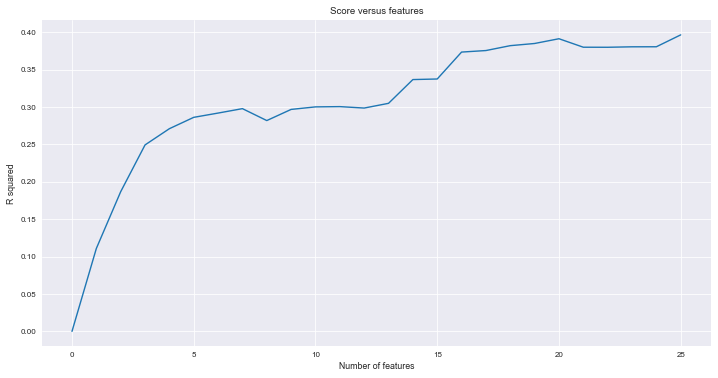

In [40]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores)
plt.show()

In [41]:
nnbfs, nnbs, model_scores = order_best_features_and_score(X_train[best_features], y_train, X_train[best_features], y_train)
print("New Best Score :", nnbs)
print(nnbfs)

New Best Score : 0.25225661055670157
['milk' 'hot dogs bacon sausage' 'packaged cheese' 'fresh vegetables'
 'packaged vegetables fruits' 'instant foods' 'soy lactosefree'
 'pasta sauce' 'beers coolers' 'tofu meat alternatives' 'yogurt'
 'canned meat seafood' 'frozen breakfast' 'spreads' 'energy sports drinks'
 'dry pasta' 'soft drinks' 'hot cereal pancake mixes' 'juice nectars'
 'cereal' 'fresh herbs' 'eggs']


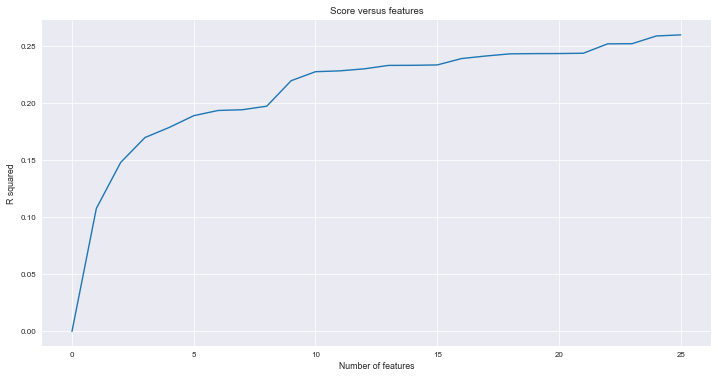

In [42]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores)
plt.show()

### Specific User Investigation

In [ ]:
# For the User
train_orders_prod, test_orders_prod = join_products(user_train_orders, user_test_orders)
wanted_info_train = train_orders_prod[key_cols]
wanted_info_test = test_orders_prod[key_cols]
df_with_aisle_info_train = add_each_aisle_to_df(wanted_info_train)
df_with_aisle_info_test = add_each_aisle_to_df(wanted_info_test)
cols_to_drop = ["aisle", "aisle_id", "order_id"]
item = "aisle"
df_aisle_group_train = group_by_order_in_df(df_with_aisle_info_train, item, cols_to_drop)
df_aisle_group_test = group_by_order_in_df(df_with_aisle_info_test, item, cols_to_drop)
X_train, y_train, X_test, y_test = split_data_to_features_and_value(df_aisle_group_train, df_aisle_group_test)
best_features, best_score, model_scores = order_best_features_and_score(X_train, y_train, X_test, y_test)
print("Best Score :", best_score)
print(best_features)

In [ ]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores)
plt.show()

In [ ]:
best_features, best_score, model_scores = order_best_features_and_score(X_train[best_features], y_train, X_test[best_features], y_test)
print("Best Score :", best_score)
print(best_features)

In [ ]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores)
plt.show()

In [ ]:
# NOW WE WANT TO USE PCA/REGULARISATION AND REMOVE SOME UNNEEDED INFO/AISLES

In [ ]:
# DONT FORGET TO MEAN CENTRE